<a href="https://colab.research.google.com/github/jpequegn/wkoAnalysis/blob/master/notebooks/PDC%20Curve%20Fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Bike / Run Power Duration Curve fitting

In [1]:
!pip install -q torch torchvision numpy pandas matplotlib lmfit jax

     |████████████████████████████████| 292 kB 9.6 MB/s 
     |████████████████████████████████| 40 kB 5.5 MB/s 
     |████████████████████████████████| 98 kB 7.0 MB/s 


In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from lmfit import Model, Parameters
from jax import grad

# Import the data from a CSV (Secs, Watts)

In [3]:
df = pd.read_csv("./mmpcurve-b0118.csv")

## Let's try to implement the WKO model
The model seems to follow the following formula: P(t) = FRC / t * (1-exp(-t/tau)) + FTP * (1-exp(-t/tau2))
       [-a * Ln(t/TTE) if t>TTE]
       
       
FRC: Functional Reserve Capacity

FTP: Functional Threshold Power

TTE: Time To Exhaustion

Other parameters have less direct traceability / meaning but lim(tau, t->0) is close to FRC/Pmax

## 1st option: Using LMFIT

In [4]:
def power_curve(x, frc, ftp, tte, tau, tau2, a):
    p = frc / x * (1.0 - np.exp(-x / tau)) + ftp * (1 - np.exp(-x / tau2))
    p -= np.maximum(0, a * np.log(x / tte))
    return p

In [5]:
def fit_curve(df_x, df_y, maxtau=20, maxtau2=20):

    gmodel = Model(power_curve)
    params = Parameters()
    params.add('frc', value=5000, min=1, max=15000)
    params.add('ftp', value=200, min=150, max=400)
    params.add('tte', value=2000, min=1800, max=3600)
    params.add('tau', value=12, min=10, max=maxtau)
    params.add('tau2', value=30, min=10, max=maxtau2)
    params.add('a', value=10, min=1, max=200)
    
    result = gmodel.fit(df_y, params, x=df_x)
    fit = power_curve(df_x, result.best_values['frc'], result.best_values['ftp'], 
                  result.best_values['tte'], result.best_values['tau'],
                  result.best_values['tau2'], result.best_values['a'])

    return result, fit

In [6]:
df_x = df['Secs']
df_y = df['Watts']

In [7]:
gmodel = Model(power_curve)
print('parameter names: {}'.format(gmodel.param_names))
print('independent variables: {}'.format(gmodel.independent_vars))

parameter names: ['frc', 'ftp', 'tte', 'tau', 'tau2', 'a']
independent variables: ['x']


In [8]:
result, fit = fit_curve(df_x, df_y)
result.best_values

{'a': 27.512112407095092,
 'frc': 9397.04813947771,
 'ftp': 235.67312780482652,
 'tau': 17.361022647219126,
 'tau2': 20.0,
 'tte': 1800.0000797805342}

In [9]:
# %matplotlib widget

In [10]:
def plotFittedCurve(df_x, df_y, fit):
  plt.figure(figsize=(10,6))
  plt.plot(df_x, df_y, label='MMP')
  plt.plot(df_x, fit, label='PDC')
  plt.legend()
  plt.grid(True)
  plt.xscale('log')
  plt.show()

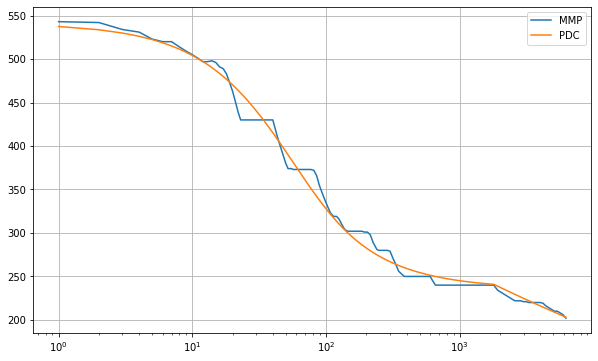

In [11]:
plotFittedCurve(df_x, df_y, fit)

In [12]:
def plotResiduals(df_x, result):
  plt.ion()
  plt.figure(figsize=(10,6))
  plt.plot(df_x, result.residual, label='residuals')
  plt.grid(True)
  plt.title('Normalized residuals')
  plt.legend()
  plt.xscale('log')

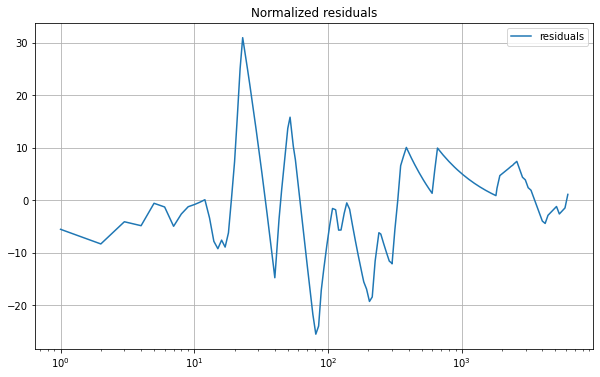

In [13]:
plotResiduals(df_x, result)

## What does a healthy curve for FTP 250w looks like?

In [14]:
tgt_frc = 10000 # 10k of FRC
tgt_ftp = 240
tgt_tte = 2700  # 45 mins of TTE
tgt_tau = 18
tgt_tau2 = 18
tgt_a = 16
tgt_crv = power_curve(df_x, tgt_frc, tgt_ftp, tgt_tte, tgt_tau, tgt_tau2, tgt_a)

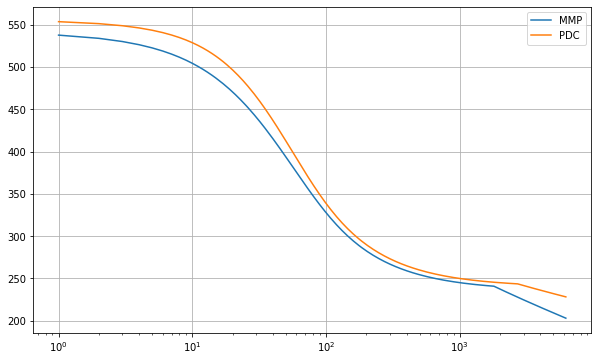

In [15]:
plotFittedCurve(df_x, fit, tgt_crv)

In [16]:
# Look up target value at a given point in curve
secs = 420
i = len(df_x[df_x.lt(secs)])

print("Current power at {} secs: {:n}, target: {:n}".format(secs, fit[i], tgt_crv[i]))

Current power at 420 secs: 258.047, target: 263.81


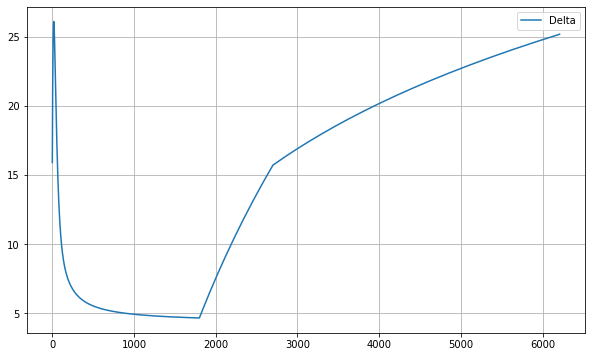

In [17]:
delta = tgt_crv - fit
plt.figure(figsize=(10,6))
plt.plot(df_x, delta, label='Delta')
plt.legend()
plt.grid(True)


## How would a new best effort affect the curve / measures?

In [18]:
def addNewBest(df, sec, watt):
    newbest = (df['Secs']<=sec) & (df['Watts']<watt)
    df.loc[newbest, "Watts"] = watt

In [19]:
# take a deep copy of the dataframe before modifying it
df_temp = df.copy(deep=True)

In [20]:
# Add some new bests to the MMP curve - then calculate the impact on FRC, FTP and TTE
addNewBest(df_temp, 420, 265)

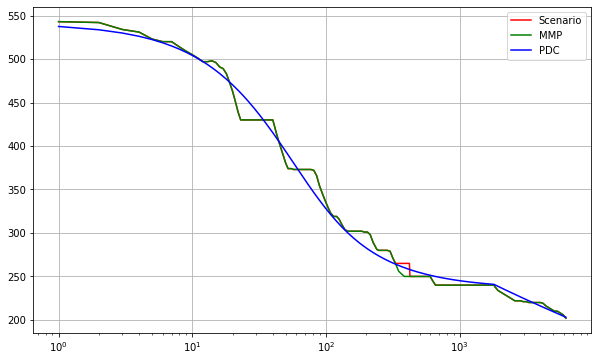

In [21]:
plt.figure(figsize=(10,6))
plt.plot(df_x, df_temp['Watts'], label='Scenario', color='r')
plt.plot(df_x, df['Watts'], label='MMP', color='g')
plt.plot(df_x, fit, label='PDC', color='b')
plt.grid(True)
plt.legend()
plt.xscale('log')

In [22]:
result_scen, fit_scen = fit_curve(df_temp['Secs'], df_temp['Watts'])
result.best_values, result_scen.best_values

({'a': 27.512112407095092,
  'frc': 9397.04813947771,
  'ftp': 235.67312780482652,
  'tau': 17.361022647219126,
  'tau2': 20.0,
  'tte': 1800.0000797805342},
 {'a': 28.921082622582297,
  'frc': 9330.887869064034,
  'ftp': 236.8406758706182,
  'tau': 17.224177914847132,
  'tau2': 20.0,
  'tte': 1800.0000006511625})

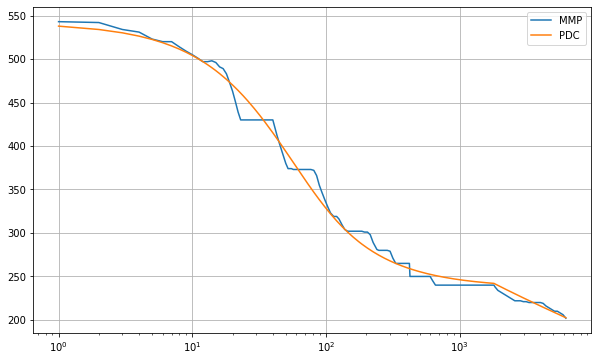

In [23]:
plotFittedCurve(df_x, df_temp['Watts'], fit_scen)

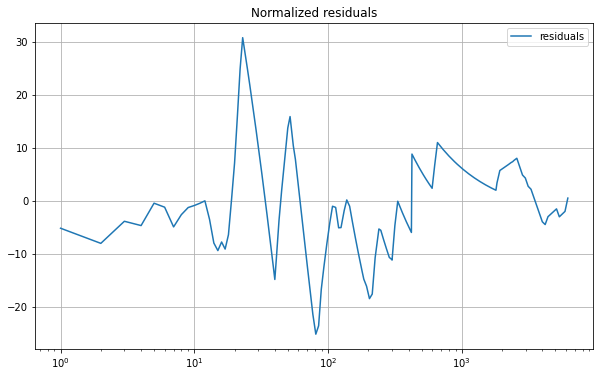

In [24]:
plotResiduals(df_x, result_scen)

In [25]:
def calcVo2max(power, weight):
  return (0.0108 * power + 0.007 * weight) / weight * 1000

In [26]:
weight = 65
power3min = df_temp[df_temp['Secs']==180]['Watts']
calcVo2max(power3min, weight)

67    57.178462
Name: Watts, dtype: float64

In [28]:
power3min

67    302
Name: Watts, dtype: int64

In [33]:
# estimate Vo2max
calcVo2max(302, 64.7)

57.41112828438949

In [34]:
# At 70kg, each watt increase vo2max by 0.15 -> need about 6w increase for 1 vo2max point
grad_p = grad(calcVo2max, argnums=0)
grad_p(300.0, 70.0)

DeviceArray(0.15428571, dtype=float32)

In [35]:
# At stable watt, you get an extra point of Vo2max for a loss of 0.66kg
grad_kg = grad(calcVo2max, 1)
grad_kg(300.0, 70.0)

DeviceArray(-0.6612245, dtype=float32)

## 2nd option: Approximate the PDC with a FC neural net

Basic implementation in Pytorch

In [ ]:
inp = 1
hidden = 30
out = 1
lr = 1e-3

In [ ]:
model = torch.nn.Sequential(
    torch.nn.Linear(inp, hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden, hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden, hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden, out)
)

In [ ]:
loss_fn = torch.nn.MSELoss(reduction='sum')

In [ ]:
# Generate some training data based on the true function
x = torch.tensor(df['Secs'].values.astype(np.float32).reshape(len(df),1))
y = torch.tensor(df['Watts'].values.astype(np.float32).reshape(len(df),1))


In [ ]:
optim = torch.optim.Adam(model.parameters(), lr = lr)

In [ ]:
for i in range(30001):
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    if (i%5000)==0:
        print('Epoch {}, Loss: {:2f}'.format(i, loss.item()))
    
    optim.zero_grad()
    loss.backward()
    optim.step()

Epoch 0, Loss: 19675676.000000
Epoch 5000, Loss: 16274.308594
Epoch 10000, Loss: 3147.900391
Epoch 15000, Loss: 34116.281250
Epoch 20000, Loss: 7239.381836
Epoch 25000, Loss: 2216.297607
Epoch 30000, Loss: 3434.020508


In [ ]:
model.eval()

Sequential(
  (0): Linear(in_features=1, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=30, bias=True)
  (3): ReLU()
  (4): Linear(in_features=30, out_features=30, bias=True)
  (5): ReLU()
  (6): Linear(in_features=30, out_features=1, bias=True)
)

In [ ]:
predicted_tensor = model(x)
predicted = predicted_tensor.detach().numpy()

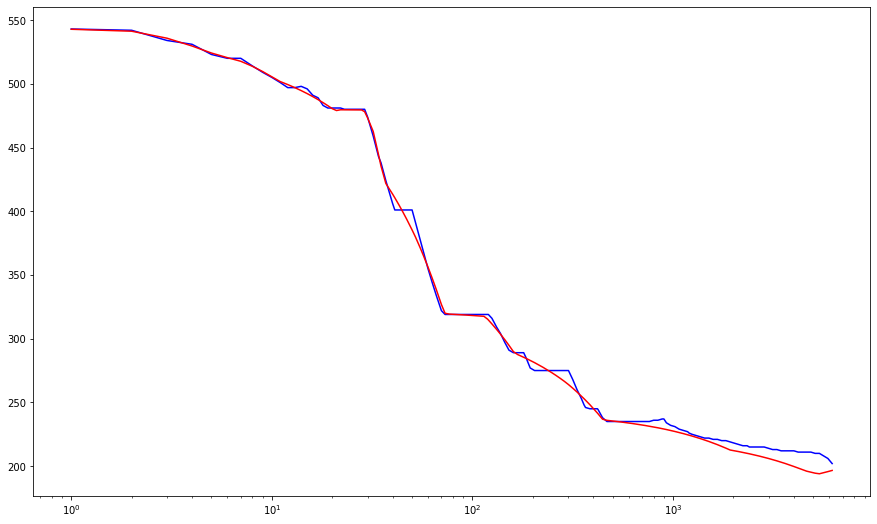

In [ ]:
plt.figure(figsize=(15,9))
plt.plot(x, y, label='orig', c='b')
plt.plot(x, predicted, label='predict', c='r')
plt.xscale('log')

In [ ]:
# What is the predicted power at 10 mins
test = torch.tensor(np.array([[600,]], dtype=np.float32))
predict = model(test)
predict

tensor([[233.8497]], grad_fn=<AddmmBackward0>)

## 3rd option: Use Pytorch autograd to fit the power curve

In [ ]:
def power(x):
    p = frc / x * (1.0 - np.exp(-x / tau)) + ftp * (1 - np.exp(-x / tau2))
    p -= np.maximum(0, a * np.log(x/tmap))
    return p

In [ ]:
frc = torch.ones(1, dtype=torch.float, requires_grad=True)
ftp = torch.ones(1, dtype=torch.float, requires_grad=True)
tau = 14.7
tau2 = 40
tmap = 1450
a = 22

In [ ]:
optim = torch.optim.Adam([frc, ftp], lr = 0.1)

In [ ]:
loss_fn = torch.nn.MSELoss(reduction='sum')

In [ ]:
# Generate some training data based on the true function
x = torch.tensor(df['Secs'].values.astype(np.float32).reshape(len(df),1))
y = torch.tensor(df['Watts'].values.astype(np.float32).reshape(len(df),1))

In [ ]:
for i in range(100000):
    y_pred = power(x)
    loss = loss_fn(y_pred, y)
    if (i%10000)==0:
        print('Epoch {}, Loss: {:2f}'.format(i, loss.item()))
    
    optim.zero_grad()
    loss.backward()
    optim.step()

Epoch 0, Loss: 101629.031250
Epoch 10000, Loss: 101229.406250
Epoch 20000, Loss: 101229.414062
Epoch 30000, Loss: 101229.398438
Epoch 40000, Loss: 101229.398438
Epoch 50000, Loss: 101229.406250
Epoch 60000, Loss: 101229.398438
Epoch 70000, Loss: 101229.406250
Epoch 80000, Loss: 101229.406250
Epoch 90000, Loss: 101229.390625


In [ ]:
frc, ftp

(tensor([9608.8174], requires_grad=True),
 tensor([236.6632], requires_grad=True))

In [ ]:
predicted_tensor = power(x)
predicted = predicted_tensor.detach().numpy()

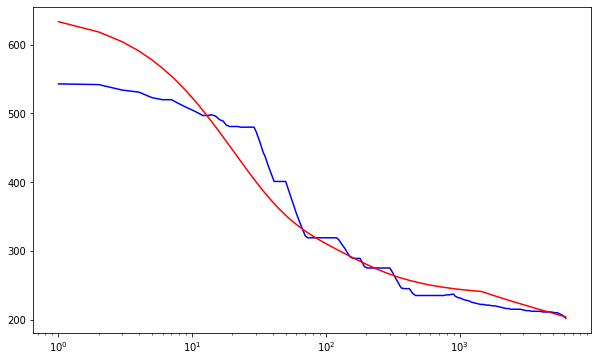

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(x, y, label='orig', c='b')
plt.plot(x, predicted, label='predict', c='r')
plt.xscale('log')